<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>


In this notebook, we reproduce some of the experiments of J. Pennington et al., 2015. The extensive statistics are performed <a href= "http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-stats.ipynb"> here </a>.

In [3]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
%matplotlib inline 
from matplotlib import pyplot as plt 
import matplotlib as mpl
data = '../data/'

Import the KernelApprox and SRFF Classes implemented in <a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-I.ipynb"> SRF - Polynomial Kernel - Implementation I </a>  and <a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-II.ipynb"> SRF - Polynomial Kernel - Implementation II </a> 

In [1]:
from KernelApprox import*
from SRFF import*

# Experiments: 

#### Let's try to reproduce the experimental results of J. Pennington et al., 2015 on USPS and Gisette datasets. 

In [37]:
from sklearn.metrics.pairwise import  polynomial_kernel, linear_kernel
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from scipy.io import loadmat 

usps = loadmat(data + "usps.mat")
X_usps, y_usps = np.vstack((usps['data_train'],usps['data_test'])), np.vstack((usps['label_train'],usps['label_test'])).flatten()

digits = fetch_mldata("USPS")
X_usps, y_usps = digits.data, digits.target.astype(int) - 1

X_gis = pd.read_csv(data + "gisette/X_train.txt",sep=' ',header=None).drop([5000],axis=1).values
y_gis = pd.read_csv(data + "gisette/y_train.txt",header=None).values.flatten()

print("USPS: X.shape = {} | y.shape = {} | number of classes : {}".format(X_usps.shape, y_usps.shape, len(np.unique(y_usps))))
print("Gisette: X.shape = {} | y.shape = {} | number of classes : {}".format(X_gis.shape, y_gis.shape, len(np.unique(y_gis))))


USPS: X.shape = (9298, 256) | y.shape = (9298,) | number of classes : 10
Gisette: X.shape = (6000, 5000) | y.shape = (6000,) | number of classes : 2


### 1 - USPS

We fix A = 4 and play with the degree P. For each P, we evaluate the kernel approximation before training.
In the cell below, we normalize and split the data. Normalization is mandatory to write the polynomial kernel as a single variable of z = x - y:
$$ 2<x,y>  = ||x||^2 + ||y||^2 - ||x-y||^2 = 2 - ||x-y||^2 $$ 

In [18]:
A = 4
gamma = 2/A**2
coef0 = 1 - gamma

X , y = X_usps.copy(), y_usps.copy()
X_normalization = np.sqrt((X * X).sum(axis=1))
Xnorm = X/X_normalization.reshape(-1,1)

skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=123)  
train_is, test_is = list(skf.split(Xnorm))[0]
X_train = Xnorm[train_is].copy()                                  
y_train = y[train_is].copy()
X_test = Xnorm[test_is].copy()                                    
y_test = y[test_is].copy() 

    . P = 3

In [16]:
DIM = X.shape[1]
EPS, GRID_SIZE = 1e-20, 500

P = 3

def polynomial_kernel_scalar(z, a = A, degree = P):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
Kapp.fit(eval_grid_factor=2)
cdf = Kapp.get_cdf()

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.


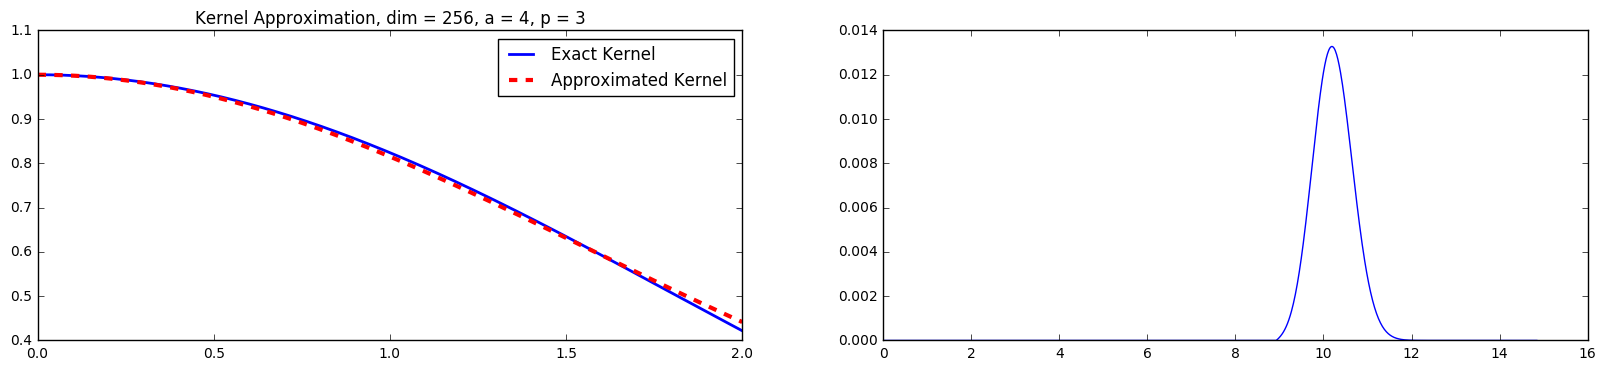

In [17]:
z = np.linspace(0,2,2*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,P))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,2*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

In [19]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time

n_features = X.shape[1]

exact_svm1 = Pipeline([
                      ('svc', OneVsRestClassifier(SVC(C=1, kernel="poly", coef0 = coef0, degree = P, gamma=gamma))),
                      ])

t = time()
exact_svm1.fit(X_train,y_train)
t_exact1 = time() - t

# Test 
y_pred1 = exact_svm1.predict(X_test)                      
error1 = 1 - accuracy_score(y_test, y_pred1)                       
print('Testing error exact SVM = %f | training time = %.3f' %(error1, t_exact1))                                                                            


Testing error exact SVM = 0.065054 | training time = 20.237


In [25]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time
Ds = [2**i for i in range(5,10)]
n_repeats = 5

srff_times1, srff_errors1 = np.zeros((len(Ds),n_repeats)), np.zeros((len(Ds),n_repeats))

for i,D in enumerate(Ds):
    srff_pip1 = Pipeline([
                ('srff',SRFF(cdf, a = A, p = P, D = D )),
                ('linsvc', OneVsRestClassifier(LinearSVC(C=1))),
             ])

    for j in range(n_repeats):
        t = time()
        srff_pip1.fit(X_train, y_train)
        srff_times1[i,j] = time() - t

        y_pred_srff1 = srff_pip1.predict(X_test)                      
        srff_errors1[i,j] = 1 - accuracy_score(y_test, y_pred_srff1)
    
print("Best SRFF performance: Testing error = %f | Training time = %.3f"%(srff_errors1[-1].mean(),srff_times1[-1].mean()))

Best SRFF performance: Testing error = 0.050215 | Training time = 2.743


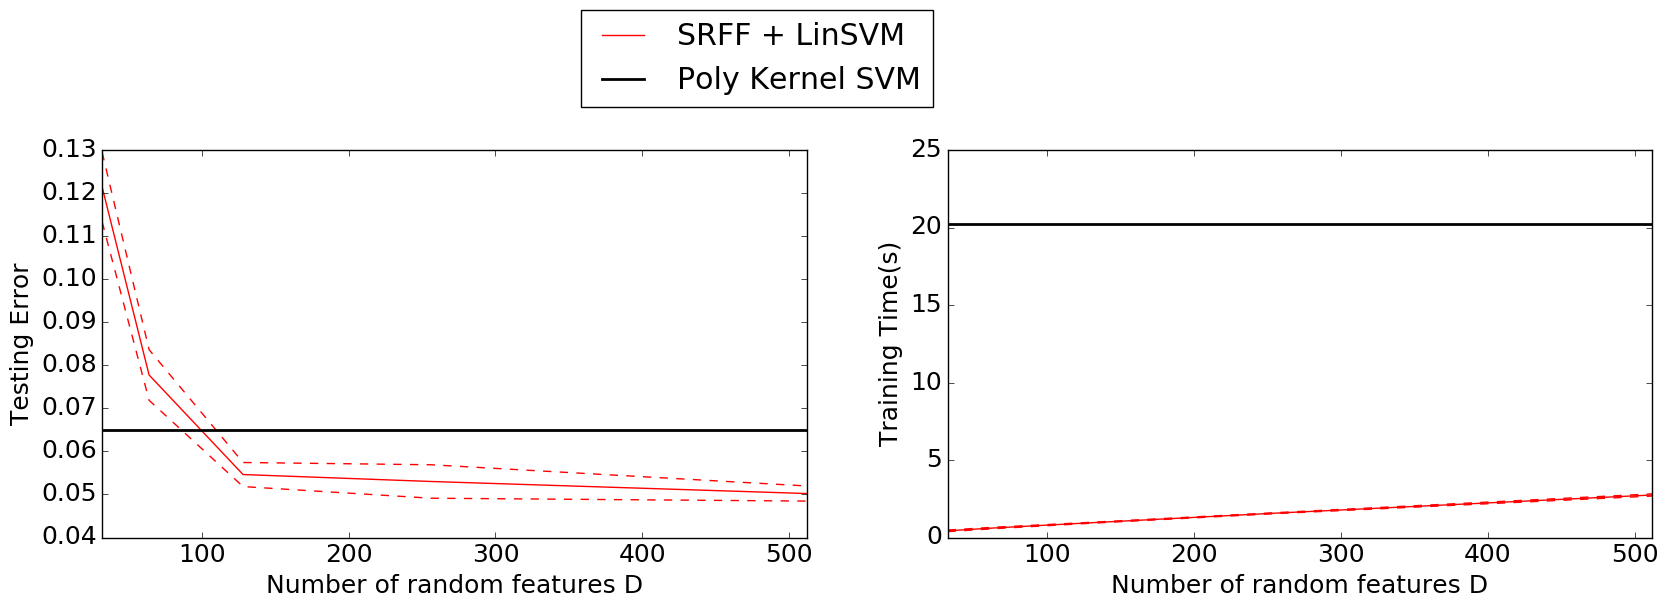

In [35]:
mean_errors = srff_errors1.mean(axis=-1)
mean_times = srff_times1.mean(axis=-1)

mpl.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Ds, mean_errors + srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors - srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors, 'r', label="SRFF + LinSVM")
plt.plot(Ds, len(Ds)*[error1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.xlim([Ds[0],Ds[-1]])
plt.ylabel("Testing Error")
plt.xlabel("Number of random features D")

plt.subplot(122)
plt.plot(Ds, mean_times + srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times - srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times, 'r', label="SRFF + LinSVM")
plt.xlim([Ds[0],Ds[-1]])
plt.plot(Ds, len(Ds)*[t_exact1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D")
plt.legend(bbox_to_anchor=[0,1.4])
plt.show()

    . P = 3

In [38]:
DIM = X.shape[1]
EPS, GRID_SIZE = 1e-20, 500

P = 20

def polynomial_kernel_scalar(z, a = A, degree = P):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
Kapp.fit(eval_grid_factor=2)
cdf = Kapp.get_cdf()

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.


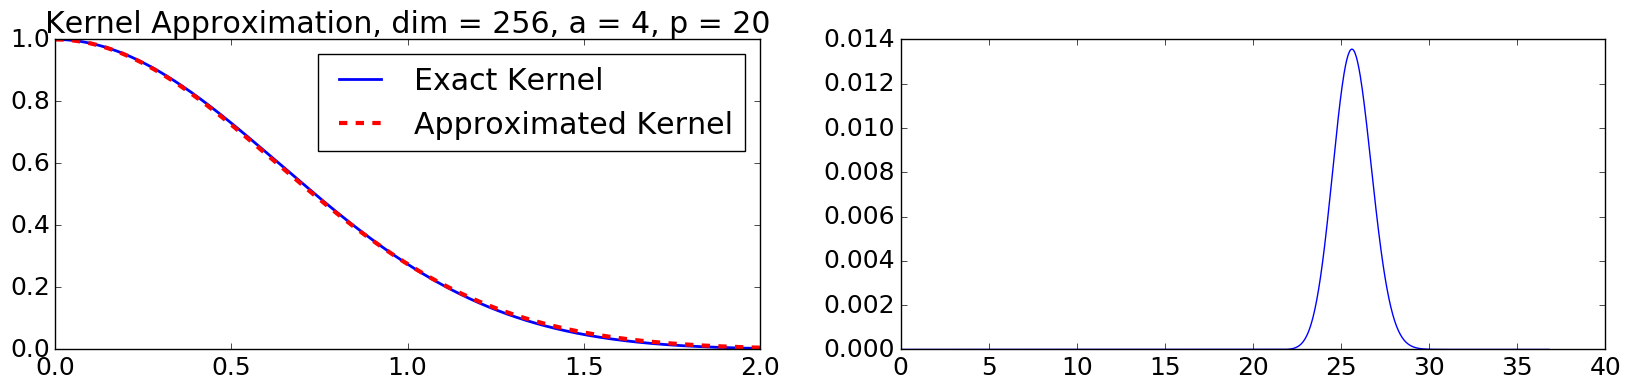

In [39]:
z = np.linspace(0,2,2*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,P))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,2*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

In [40]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time

n_features = X.shape[1]

exact_svm1 = Pipeline([
                      ('svc', OneVsRestClassifier(SVC(C=1, kernel="poly", coef0 = coef0, degree = P, gamma=gamma))),
                      ])

t = time()
exact_svm1.fit(X_train,y_train)
t_exact1 = time() - t

# Test 
y_pred1 = exact_svm1.predict(X_test)                      
error1 = 1 - accuracy_score(y_test, y_pred1)                       
print('Testing error exact SVM = %f | training time = %.3f' %(error1, t_exact1))                                                                            


Testing error exact SVM = 0.023118 | training time = 12.878


In [41]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time
Ds = [2**i for i in range(5,10)]
n_repeats = 5

srff_times1, srff_errors1 = np.zeros((len(Ds),n_repeats)), np.zeros((len(Ds),n_repeats))

for i,D in enumerate(Ds):
    srff_pip1 = Pipeline([
                ('srff',SRFF(cdf, a = A, p = P, D = D )),
                ('linsvc', OneVsRestClassifier(LinearSVC(C=1))),
             ])

    for j in range(n_repeats):
        t = time()
        srff_pip1.fit(X_train, y_train)
        srff_times1[i,j] = time() - t

        y_pred_srff1 = srff_pip1.predict(X_test)                      
        srff_errors1[i,j] = 1 - accuracy_score(y_test, y_pred_srff1)
    
print("Best SRFF performance: Testing error = %f | Training time = %.3f"%(srff_errors1[-1].mean(),srff_times1[-1].mean()))

Best SRFF performance: Testing error = 0.028387 | Training time = 2.098


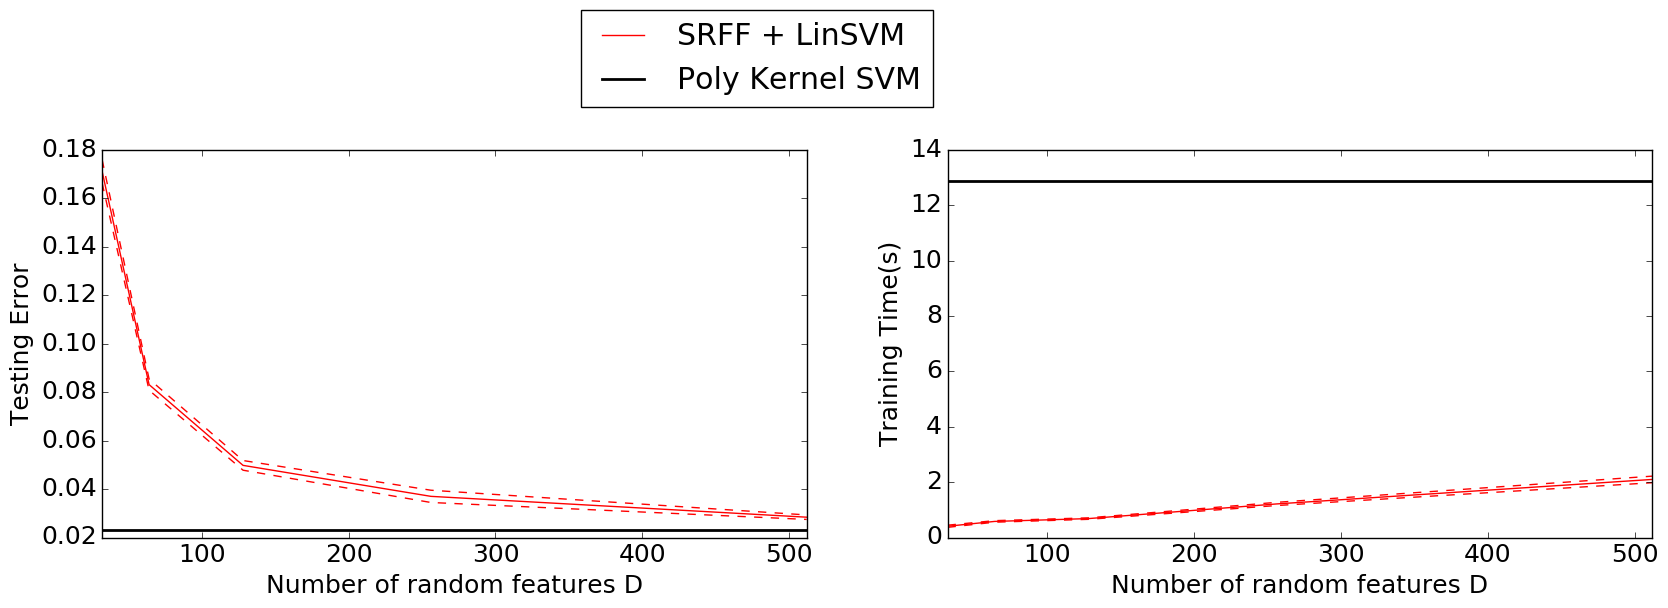

In [42]:
mean_errors = srff_errors1.mean(axis=-1)
mean_times = srff_times1.mean(axis=-1)

mpl.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Ds, mean_errors + srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors - srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors, 'r', label="SRFF + LinSVM")
plt.plot(Ds, len(Ds)*[error1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.xlim([Ds[0],Ds[-1]])
plt.ylabel("Testing Error")
plt.xlabel("Number of random features D")

plt.subplot(122)
plt.plot(Ds, mean_times + srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times - srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times, 'r', label="SRFF + LinSVM")
plt.xlim([Ds[0],Ds[-1]])
plt.plot(Ds, len(Ds)*[t_exact1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D")
plt.legend(bbox_to_anchor=[0,1.4])
plt.show()

### 2 - Gisette

We fix A = 4 and play with the degree P. For each P, we evaluate the kernel approximation before training.
In the cell below, we normalize and split the data. Normalization is mandatory to write the polynomial kernel as a single variable of z = x - y:
$$ 2<x,y>  = ||x||^2 + ||y||^2 - ||x-y||^2 = 2 - ||x-y||^2 $$ 

<h2><font color="red"> For Gisette, the dimension is too large (5000). We get an overflow error. Apparently, the objective function cannot be computed (on this machine) for dim > 2049 </font></h2>

To circument this limitation, we perform a PCA projection on 2049 components and renormalize the data.



In [83]:
A = 4
gamma = 2/A**2
coef0 = 1 - gamma

X , y = X_gis.copy(), y_gis.copy()

from sklearn.decomposition import PCA
pca = PCA(n_components=2049)
X = pca.fit_transform(X)

X_normalization = np.sqrt((X * X).sum(axis=1))
Xnorm = X/X_normalization.reshape(-1,1)

skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=123)  
train_is, test_is = list(skf.split(Xnorm))[0]
X_train = Xnorm[train_is].copy()                                  
y_train = y[train_is].copy()
X_test = Xnorm[test_is].copy()                                    
y_test = y[test_is].copy() 

    . P = 3

In [92]:
DIM = 2049
EPS, GRID_SIZE = 1e-20, 500

P = 3

def polynomial_kernel_scalar(z, a = A, degree = P):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
Kapp.fit(eval_grid_factor=2)
cdf = Kapp.get_cdf()

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.


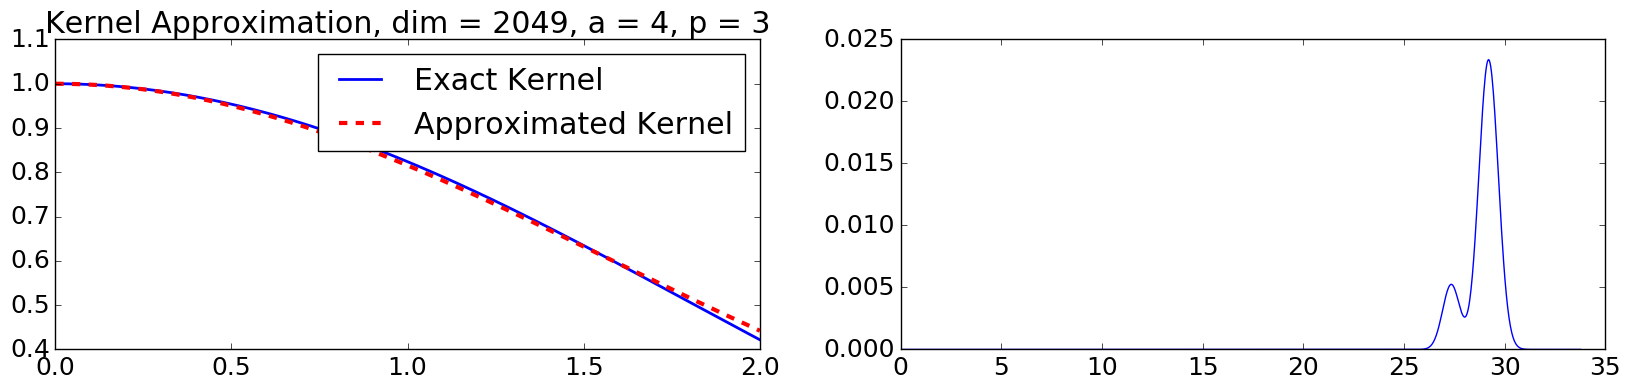

In [93]:
z = np.linspace(0,2,2*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,P))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,2*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

In [86]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time

n_features = X.shape[1]

exact_svm1 = Pipeline([
                      ('svc', OneVsRestClassifier(SVC(C=1, kernel="poly", coef0 = coef0, degree = P, gamma=gamma))),
                      ])

t = time()
exact_svm1.fit(X_train,y_train)
t_exact1 = time() - t

# Test 
y_pred1 = exact_svm1.predict(X_test)                      
error1 = 1 - accuracy_score(y_test, y_pred1)                       
print('Testing error exact SVM = %f | training time = %.3f' %(error1, t_exact1))                                                                            


Testing error exact SVM = 0.035833 | training time = 18.744


In [96]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time
Ds = [2**i for i in range(5,12)]
n_repeats = 5

srff_times1, srff_errors1 = np.zeros((len(Ds),n_repeats)), np.zeros((len(Ds),n_repeats))

for i,D in enumerate(Ds):
    srff_pip1 = Pipeline([
                ('srff',SRFF(cdf, a = A, p = P, D = D )),
                ('linsvc', OneVsRestClassifier(LinearSVC(C=1))),
             ])

    for j in range(n_repeats):
        t = time()
        srff_pip1.fit(X_train, y_train)
        srff_times1[i,j] = time() - t

        y_pred_srff1 = srff_pip1.predict(X_test)                      
        srff_errors1[i,j] = 1 - accuracy_score(y_test, y_pred_srff1)
    
print("Best SRFF performance: Testing error = %f | Training time = %.3f"%(srff_errors1[-1].mean(),srff_times1[-1].mean()))

Best SRFF performance: Testing error = 0.040333 | Training time = 2.794


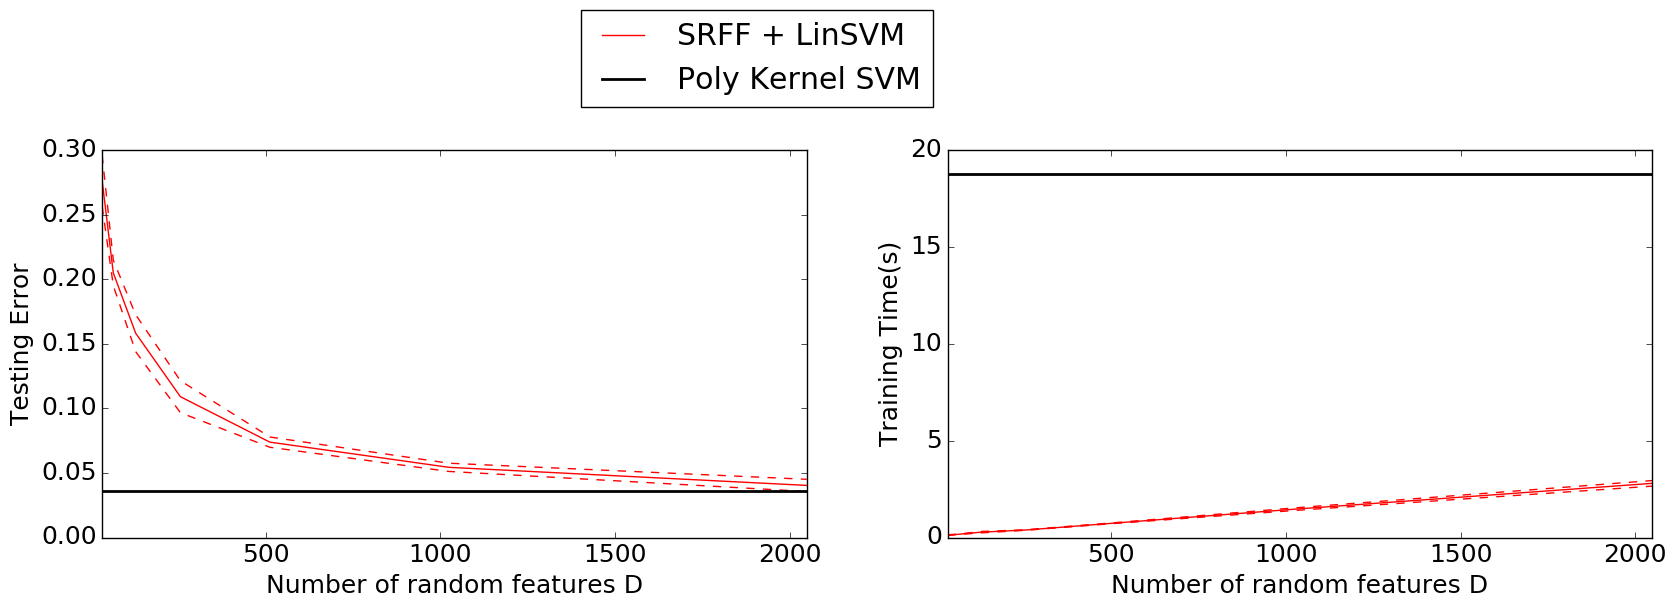

In [97]:
mean_errors = srff_errors1.mean(axis=-1)
mean_times = srff_times1.mean(axis=-1)

mpl.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Ds, mean_errors + srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors - srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors, 'r', label="SRFF + LinSVM")
plt.plot(Ds, len(Ds)*[error1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.xlim([Ds[0],Ds[-1]])
plt.ylabel("Testing Error")
plt.xlabel("Number of random features D")

plt.subplot(122)
plt.plot(Ds, mean_times + srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times - srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times, 'r', label="SRFF + LinSVM")
plt.xlim([Ds[0],Ds[-1]])
plt.plot(Ds, len(Ds)*[t_exact1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D")
plt.legend(bbox_to_anchor=[0,1.4])
plt.show()

    . P = 20

In [102]:
DIM = X.shape[1]
EPS, GRID_SIZE = 1e-20, 500

P = 20

def polynomial_kernel_scalar(z, a = A, degree = P):
    return (1- (z/a)**2)**degree

Kapp = KernelApprox(dim = DIM, kernelfunc = polynomial_kernel_scalar, eps = EPS, grid_size=GRID_SIZE, N = 10)
Kapp.fit(eval_grid_factor=2)
cdf = Kapp.get_cdf()

Launching L-BFGS ...
Converged.
Estimating PDF and Kernel approximation on the given grid ...
Done.


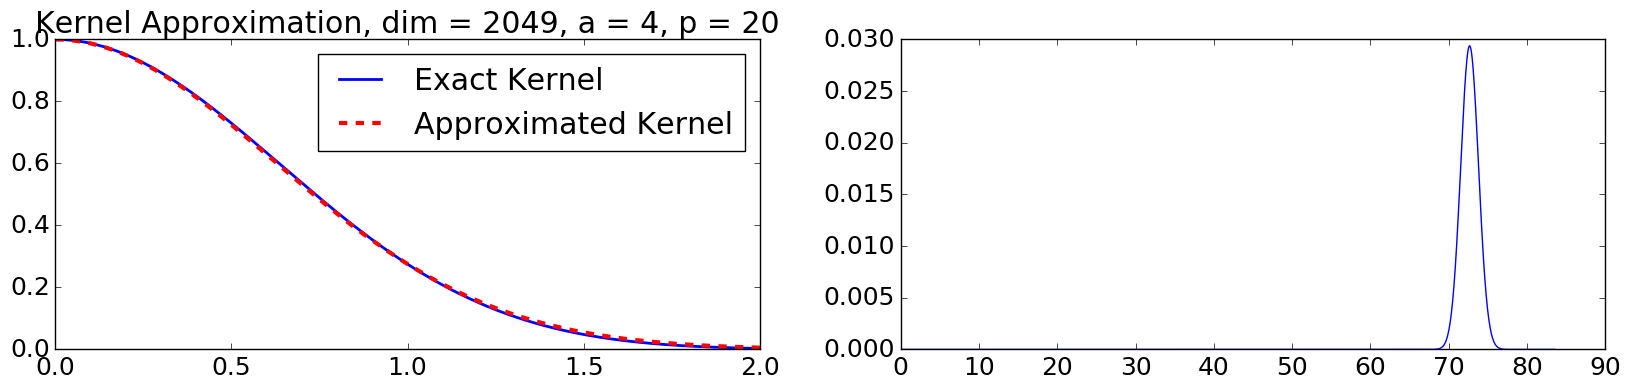

In [103]:
z = np.linspace(0,2,2*GRID_SIZE)
plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(z,polynomial_kernel_scalar(z),linewidth=2, label = "Exact Kernel")
plt.plot(z,Kapp.get_kernel_approx(),'r--',linewidth=3, label = "Approximated Kernel")
plt.title("Kernel Approximation, dim = {}, a = {}, p = {}".format(DIM,A,P))
plt.legend()
plt.subplot(122)
wmax = Kapp.get_cdf()[-1][0]
w = np.linspace(0,wmax,2*GRID_SIZE)
plt.plot(w,Kapp.get_pdf())
plt.show()

In [104]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time

n_features = X.shape[1]

exact_svm1 = Pipeline([
                      ('svc', OneVsRestClassifier(SVC(C=1, kernel="poly", coef0 = coef0, degree = P, gamma=gamma))),
                      ])

t = time()
exact_svm1.fit(X_train,y_train)
t_exact1 = time() - t

# Test 
y_pred1 = exact_svm1.predict(X_test)                      
error1 = 1 - accuracy_score(y_test, y_pred1)                       
print('Testing error exact SVM = %f | training time = %.3f' %(error1, t_exact1))                                                                            


Testing error exact SVM = 0.025833 | training time = 39.146


In [107]:
Ds = [2**i for i in range(5,15)]
n_repeats = 5

srff_times1, srff_errors1 = np.zeros((len(Ds),n_repeats)), np.zeros((len(Ds),n_repeats))

for i,D in enumerate(Ds):
    srff_pip1 = Pipeline([
                ('srff',SRFF(cdf, a = A, p = P, D = D )),
                ('linsvc', OneVsRestClassifier(LinearSVC(C=1))),
             ])

    for j in range(n_repeats):
        t = time()
        srff_pip1.fit(X_train, y_train)
        srff_times1[i,j] = time() - t

        y_pred_srff1 = srff_pip1.predict(X_test)                      
        srff_errors1[i,j] = 1 - accuracy_score(y_test, y_pred_srff1)
    
print("Best SRFF performance: Testing error = %f | Training time = %.3f"%(srff_errors1[-1].mean(),srff_times1[-1].mean()))

Best SRFF performance: Testing error = 0.036833 | Training time = 27.011


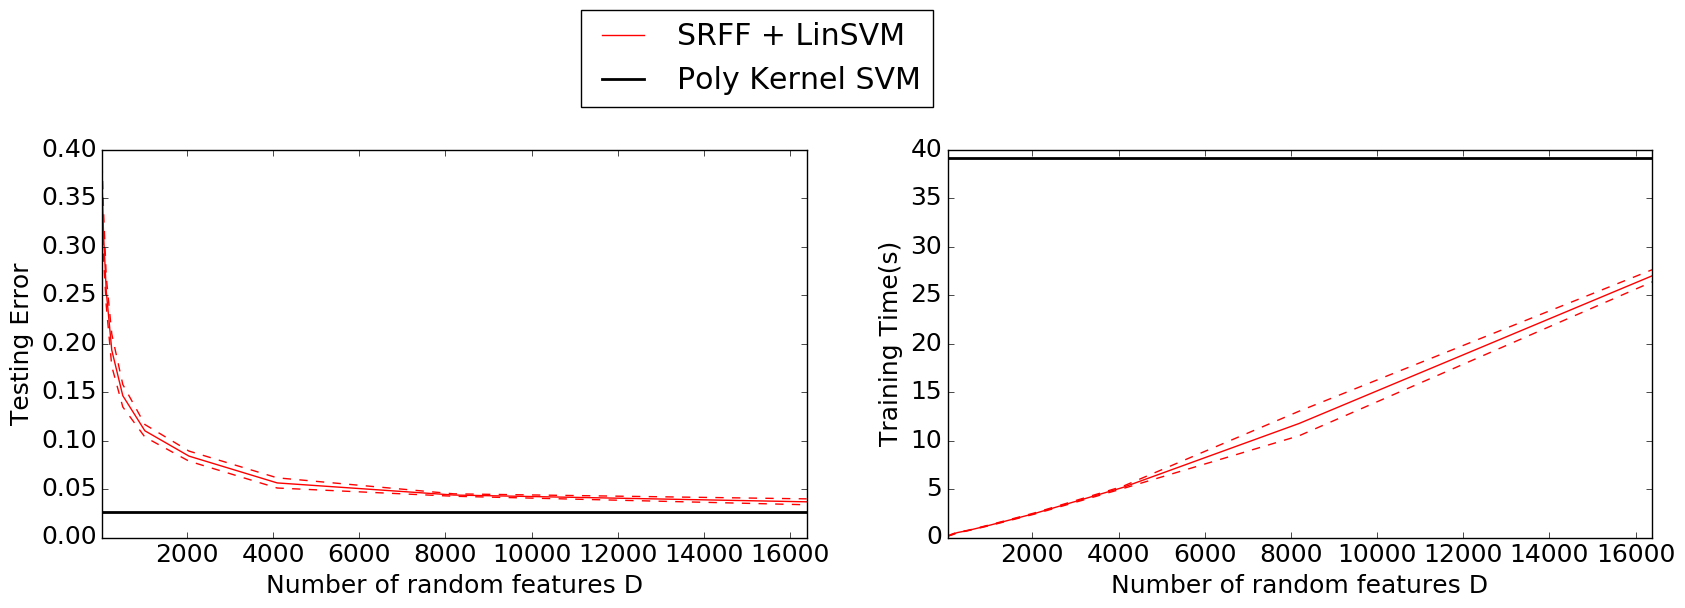

In [108]:
mean_errors = srff_errors1.mean(axis=-1)
mean_times = srff_times1.mean(axis=-1)

mpl.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Ds, mean_errors + srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors - srff_errors1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_errors, 'r', label="SRFF + LinSVM")
plt.plot(Ds, len(Ds)*[error1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.xlim([Ds[0],Ds[-1]])
plt.ylabel("Testing Error")
plt.xlabel("Number of random features D")

plt.subplot(122)
plt.plot(Ds, mean_times + srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times - srff_times1.std(axis=-1) , 'r--')
plt.plot(Ds, mean_times, 'r', label="SRFF + LinSVM")
plt.xlim([Ds[0],Ds[-1]])
plt.plot(Ds, len(Ds)*[t_exact1],'k', linewidth = 2, label="Poly Kernel SVM")
plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D")
plt.legend(bbox_to_anchor=[0,1.4])
plt.show()

# In the next notebooks:

Extensive experiments of J. pennington et al., 2015. can be found here :

<a href="http://nbviewer.jupyter.org/github/hichamjanati/srf/tree/master/SRF-stats.ipynb">

Extensive experiments </a> (figures and tables of <a href="https://github.com/hichamjanati/srf/review-srf.pdf"> my review </a>)
